In [1]:
#D'abord vérifier si on a du Lenet

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing 
from keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics
%matplotlib inline


Using TensorFlow backend.


In [3]:
def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [4]:
#Essayons de faire lenet avec tf voir ci-dessous . Il y a aussi une commande pour voir le résumer peut être .resume
def build_model(width, height, depth, classes,drop_out_rate):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(30, (5, 5), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
        
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(16, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),

        
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(128),
		Activation("relu"),
		BatchNormalization(),
		Dropout(drop_out_rate),
        
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [5]:

df=pd.read_csv("/home/marcpozzo/Desktop/c3po/Images_aquises/generateur.csv")
df=df[(df["class"]=='corneille') | (df["class"]=='pigeon') | (df["class"]=='faisan')   ]
df.drop('labels',inplace=True,axis=1)
df.head()

,class,img_paths
2,corneille,Rec_images/DSCF0180_corneille_2.JPG
3,corneille,Rec_images/DSCF0180_corneille_3.JPG
4,pigeon,Rec_images/DSCF0258_pigeon_4.JPG
8,pigeon,Rec_images/DSCF0335_pigeon_8.JPG
10,pigeon,Rec_images/DSCF0341_pigeon_10.JPG


In [6]:
#Paramètres

#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2
epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.3
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1


In [7]:

base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()


All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    

class: 13
img_paths: 6220


In [9]:
def dictionnaire_conversion():
    dic_labels_to_num={}
    dic_num_to_labels={}

    dic_labels_to_num["autre"]=0
    dic_labels_to_num["chevreuil"]=1
    dic_labels_to_num["corneille"]=2
    dic_labels_to_num["faisan"]=3
    dic_labels_to_num["lapin"]=4
    dic_labels_to_num["pigeon"]=5
    dic_labels_to_num["oiseau"]=6
    
    dic_num_to_labels[0]="autre"
    dic_num_to_labels[1]="chevreuil"
    dic_num_to_labels[2]="corneille"
    dic_num_to_labels[3]="faisan"
    dic_num_to_labels[4]="lapin"
    dic_num_to_labels[5]="pigeon"
    dic_num_to_labels[6]="oiseau"
    
    return dic_labels_to_num,dic_num_to_labels

In [10]:
dic_labels_to_num,dic_num_to_labels=dictionnaire_conversion()

n_path="/mnt/VegaSlowDataDisk/c3po/Annotation_automatique/"
gen_imagettes=pd.read_csv(n_path+"fp+an_gen_tf.csv")

folder_imagettes="tf_200ep/"

liste_img_paths=[]
for i in range(len(gen_imagettes)):
    liste_img_paths.append(n_path+folder_imagettes+gen_imagettes["imagetteName"].iloc[i])

gen_imagettes["img_paths"]=liste_img_paths
gen_imagettes.head()

gen_imagettes["class"]="autre"

for i in range(len(gen_imagettes)):
    if gen_imagettes["IsFP"].iloc[i]==0:
        gen_imagettes["class"].iloc[i]=dic_num_to_labels[gen_imagettes["reel_classe"].iloc[i]]
    
gen_imagettes.head()  



gen_imagettes=gen_imagettes[gen_imagettes["class"]!="autre"]

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'max_cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index','reel_classe','IsFP','predict_cat']
gen_imagettes.drop(to_drop,inplace=True,axis=1)
gen_imagettes.head()

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,img_paths,class
2,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
7,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
8,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,oiseau
14,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
17,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille


In [11]:
n_path="/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_images/"



fp_new=pd.read_csv("/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_threshold/table_fp_new.csv")

liste_img_paths=[]
for i in range(len(fp_new)):
    liste_img_paths.append(n_path+fp_new["imagetteName"].iloc[i])

fp_new["img_paths"]=liste_img_paths
#imagetteNamefp_new.head()

fp_new["class"]="autre"
fp_new.columns

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index']

fp_new.drop(to_drop,axis=1,inplace=True)

df=pd.concat([df,fp_new])

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [12]:
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input
        # data augmentation
        #rotation_range = 10,
        #zoom_range = zoom_range,
        #horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]


Found 40827 validated image filenames belonging to 6 classes.
Found 10207 validated image filenames belonging to 6 classes.


In [ ]:
#First test the influence of number of epochs on the other recall

In [13]:
#Nouveau
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
model.save("nex_200_total")

              precision    recall  f1-score   support

           0    0.99783   0.98886   0.99333      9785
           1    0.66667   0.94737   0.78261        19
           2    0.81860   0.88889   0.85230       198
           3    0.59701   0.93023   0.72727        43
           4    0.54286   0.95000   0.69091        20
           5    0.79518   0.92958   0.85714       142

    accuracy                        0.98570     10207
   macro avg    0.73636   0.93915   0.81726     10207
weighted avg    0.98834   0.98570   0.98659     10207

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: nex_200_total/assets


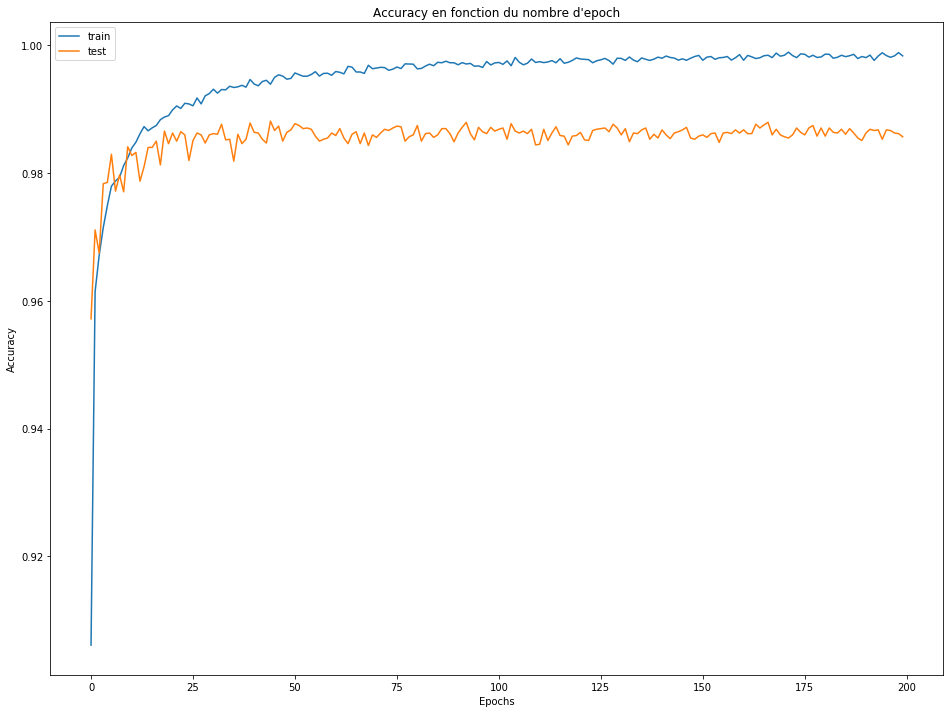

In [14]:
plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();